<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/fake_news_detection_GAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# STEP 1: SETUP AND IMPORTS
# ==========================================

# Install dependencies
!pip install torch-geometric imbalanced-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from scipy import io as sio
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.1 MB/s eta 0:00:00
✅ All libraries imported successfully!


Mounted at /content/drive
Dataset shape: (2282, 13)
Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']
First 5 rows:
     account_id       post_id    Category               Page  \
0  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
1  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
2  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
3  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
4  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   

                                            Post URL Date Published Post Type  \
0  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016     video   
1  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
2  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
3  https://www.facebook.com/ABCNewsPoliti

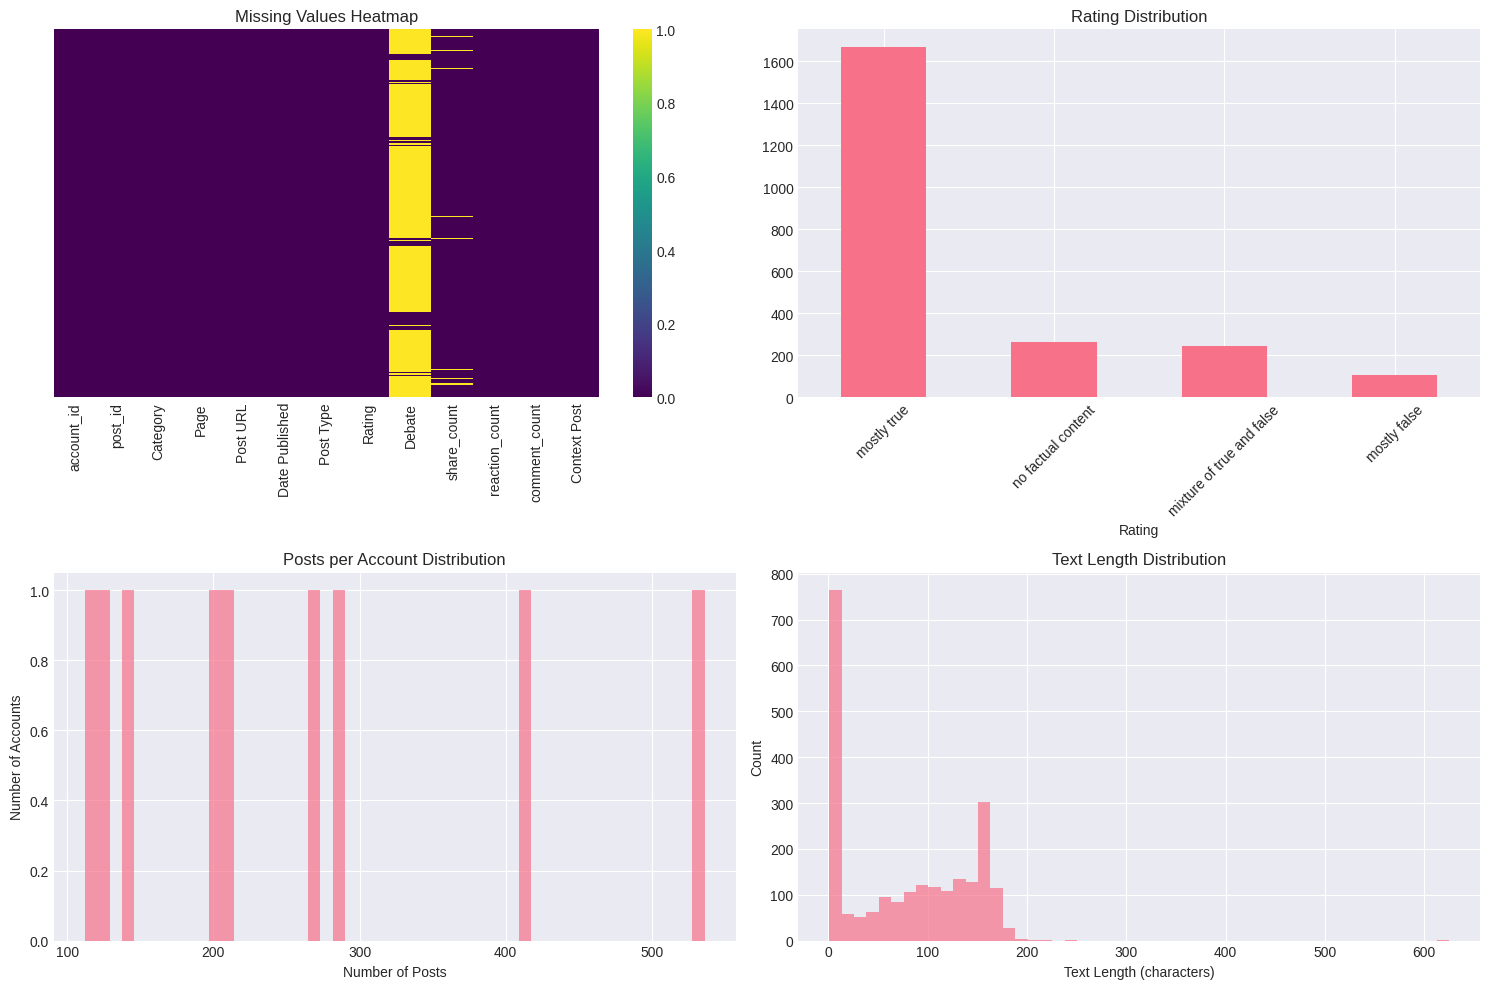

In [2]:
# ==========================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First 5 rows:")
print(df.head())

# Basic statistics
print(f"\nDataset Info:")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Visualize dataset overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Missing values heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Missing Values Heatmap')

# 2. Rating distribution
df['Rating'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Rating Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Account activity distribution
account_counts = df['account_id'].value_counts()
axes[1,0].hist(account_counts.values, bins=50, alpha=0.7)
axes[1,0].set_title('Posts per Account Distribution')
axes[1,0].set_xlabel('Number of Posts')
axes[1,0].set_ylabel('Number of Accounts')

# 4. Text length distribution
text_lengths = df['Context Post'].fillna('').str.len()
axes[1,1].hist(text_lengths, bins=50, alpha=0.7)
axes[1,1].set_title('Text Length Distribution')
axes[1,1].set_xlabel('Text Length (characters)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

✅ Network features preprocessed
Raw features shape: (2282, 3)
Processed features shape: (2282, 3)


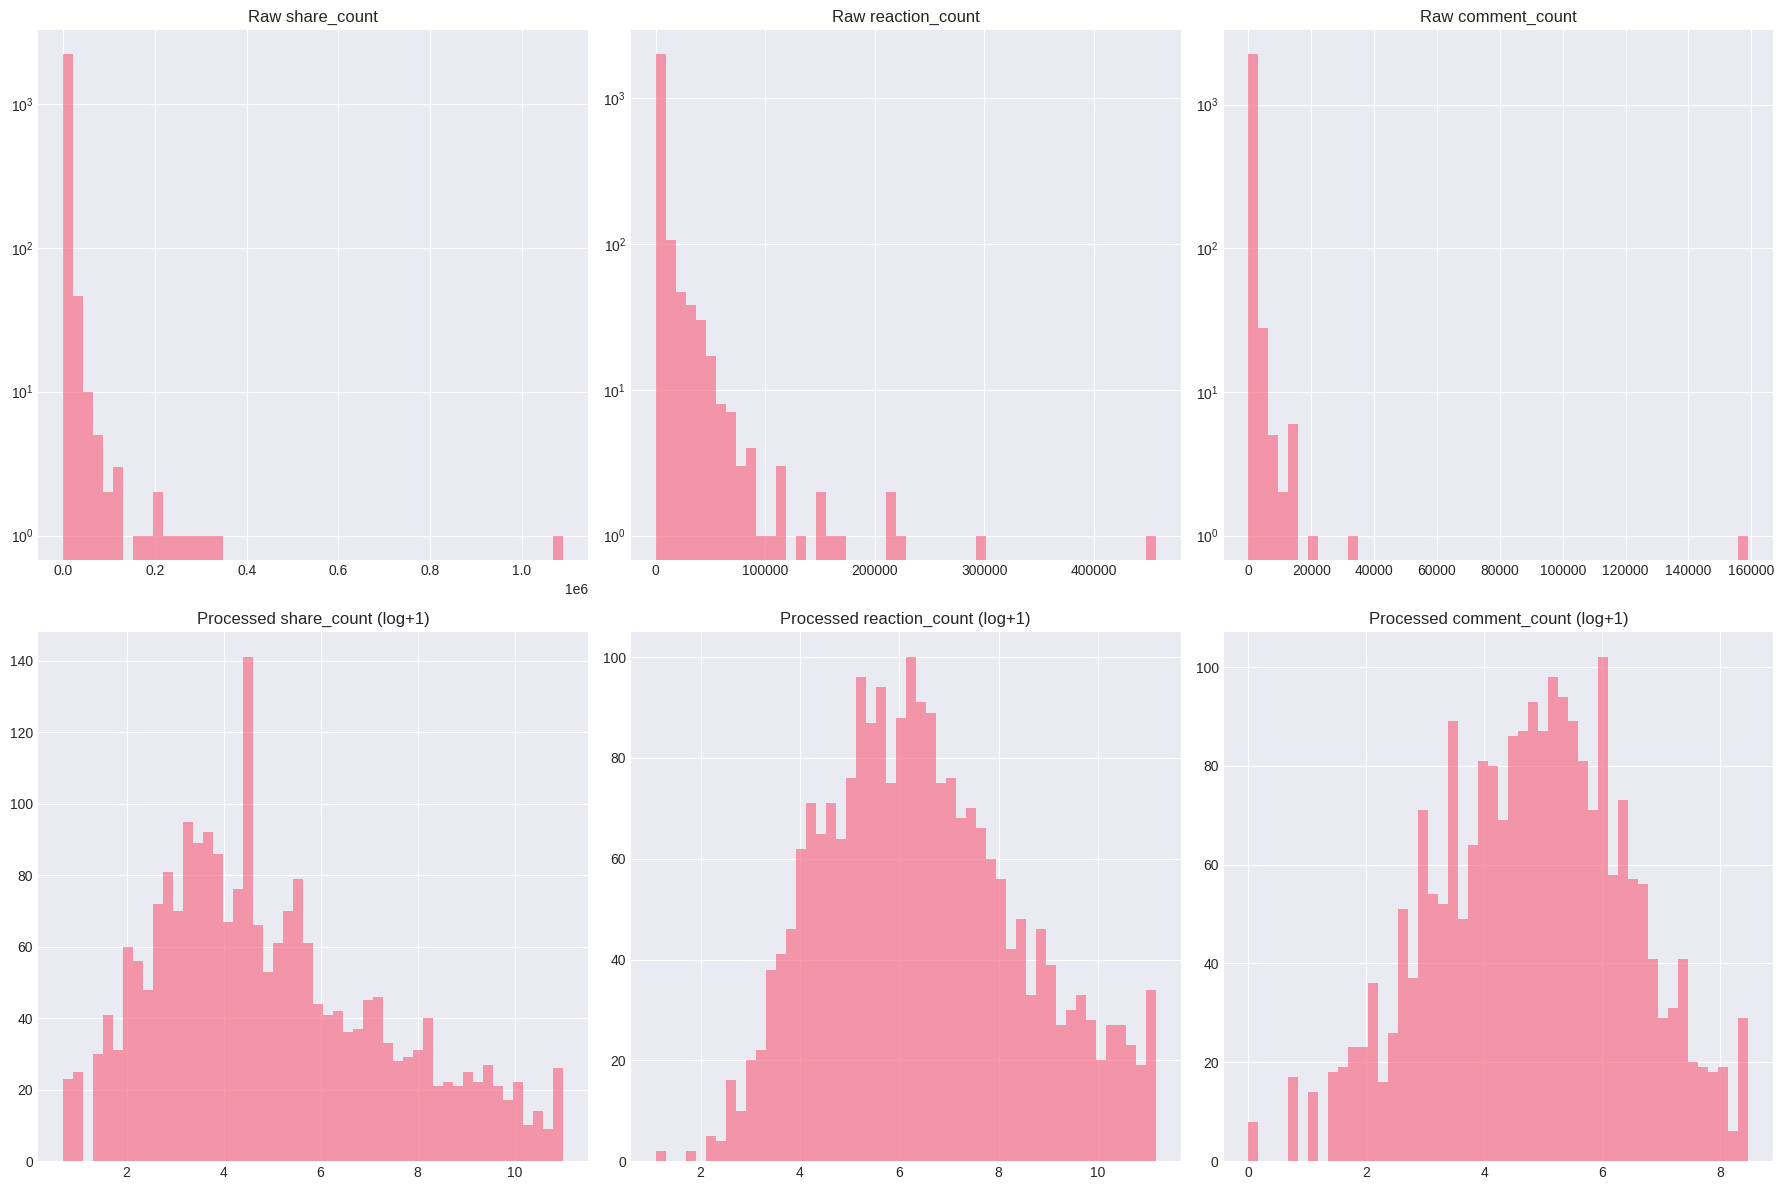

Standardized features shape: (2282, 3)
NaN check: False


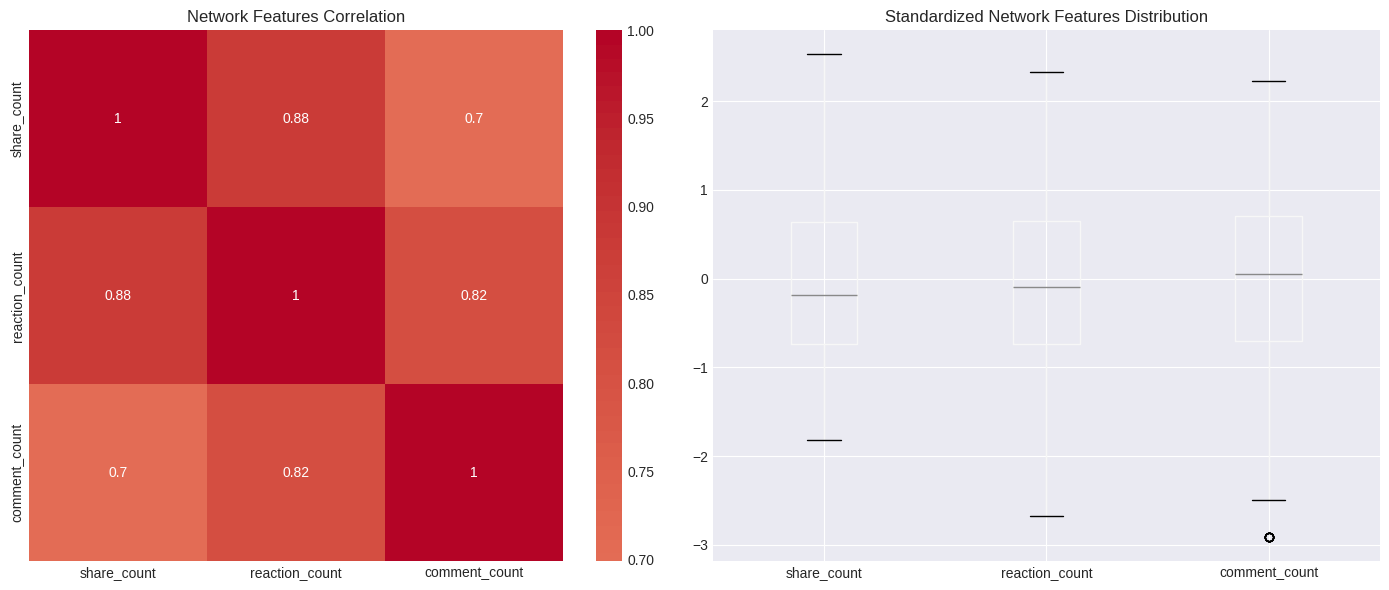

In [3]:
# ==========================================
# STEP 3: NETWORK FEATURES PREPROCESSING
# ==========================================

def preprocess_network_features(df):
    """Enhanced preprocessing with outlier handling and normalization"""
    # Extract network features
    network_cols = ['share_count', 'reaction_count', 'comment_count']
    features = df[network_cols].copy()

    # Handle missing values
    features = features.fillna(features.median())


    # Log transform to handle skewness (add 1 to avoid log(0))
    features_log = np.log1p(features)

    # Optional: Cap extreme outliers at 99th percentile
    for col in features_log.columns:
        q99 = features_log[col].quantile(0.99)
        features_log[col] = features_log[col].clip(upper=q99)

    return features_log.values, features.values

# Preprocess network features
network_features_processed, network_features_raw = preprocess_network_features(df)

print("✅ Network features preprocessed")
print(f"Raw features shape: {network_features_raw.shape}")
print(f"Processed features shape: {network_features_processed.shape}")

# Visualize network features preprocessing
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Raw features
for i, col in enumerate(['share_count', 'reaction_count', 'comment_count']):
    axes[0, i].hist(network_features_raw[:, i], bins=50, alpha=0.7)
    axes[0, i].set_title(f'Raw {col}')
    axes[0, i].set_yscale('log')

    axes[1, i].hist(network_features_processed[:, i], bins=50, alpha=0.7)
    axes[1, i].set_title(f'Processed {col} (log+1)')

plt.tight_layout()
plt.show()

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features_processed)

print(f"Standardized features shape: {X_net_std.shape}")
print(f"NaN check: {np.isnan(X_net_std).any()}")

# Save for later use
sio.savemat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat', {
    'X_net_std': X_net_std,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_
})

# Visualize correlation and distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
corr_matrix = pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Network Features Correlation')

# Distribution after standardization
pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).boxplot(ax=axes[1])
axes[1].set_title('Standardized Network Features Distribution')

plt.tight_layout()
plt.show()

Label distribution: [1669  613]
Class 0 (mostly true): 1669 (73.1%)
Class 1 (others): 613 (26.9%)


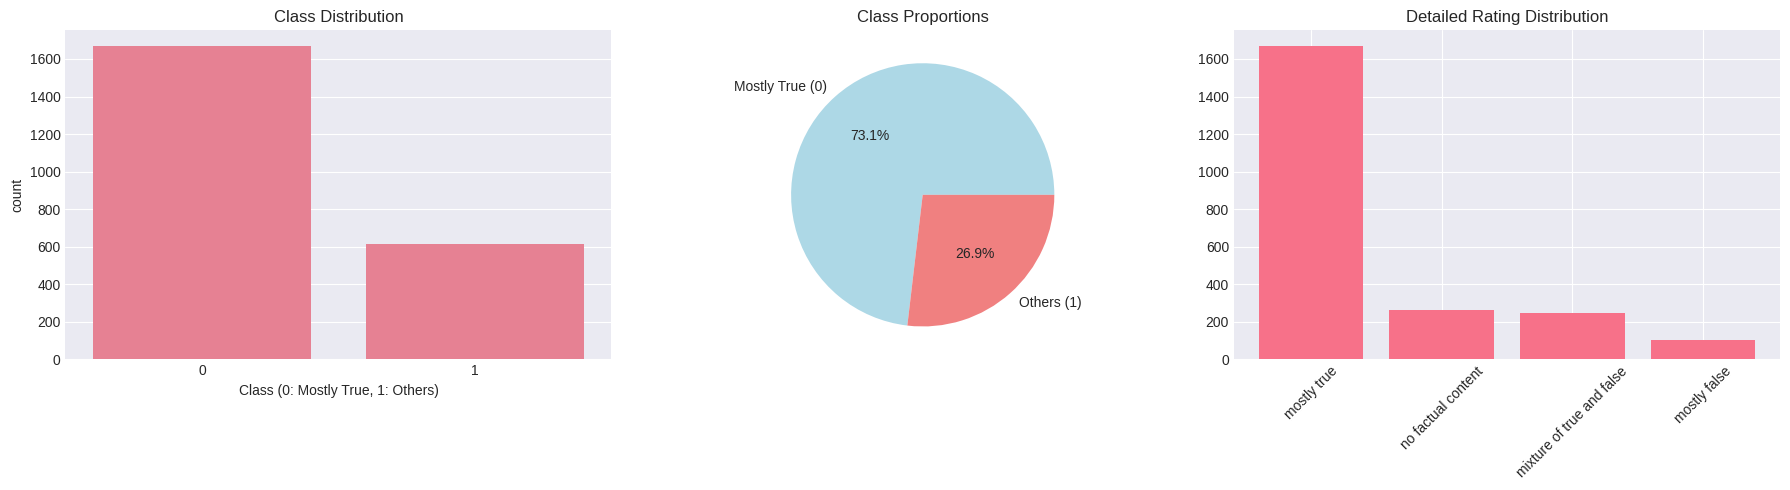

In [4]:
# ==========================================
# STEP 4: LABEL PREPARATION AND ANALYSIS
# ==========================================

# Prepare labels (binary classification)
labels = df['Rating'].apply(lambda x: 0 if x == 'mostly true' else 1).values
y = np.array(labels)

print(f"Label distribution: {np.bincount(y)}")
print(f"Class 0 (mostly true): {np.bincount(y)[0]} ({np.bincount(y)[0]/len(y)*100:.1f}%)")
print(f"Class 1 (others): {np.bincount(y)[1]} ({np.bincount(y)[1]/len(y)*100:.1f}%)")

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Count plot
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Class (0: Mostly True, 1: Others)")

# Pie chart
labels_pie = ['Mostly True (0)', 'Others (1)']
colors = ['lightblue', 'lightcoral']
axes[1].pie(np.bincount(y), labels=labels_pie, autopct='%1.1f%%', colors=colors)
axes[1].set_title("Class Proportions")

# Class distribution by rating
rating_counts = df['Rating'].value_counts()
axes[2].bar(range(len(rating_counts)), rating_counts.values)
axes[2].set_xticks(range(len(rating_counts)))
axes[2].set_xticklabels(rating_counts.index, rotation=45)
axes[2].set_title("Detailed Rating Distribution")

plt.tight_layout()
plt.show()



🔄 Constructing graph with similarity method...
Nodes: 2282, Edges: 7006
Average degree: 6.14
Degree std: 1.16

🔄 Constructing graph with account method...
Nodes: 2282, Edges: 90
Average degree: 0.08
Degree std: 0.56

🔄 Constructing graph with hybrid method...
Nodes: 2282, Edges: 4319
Average degree: 3.79
Degree std: 0.94


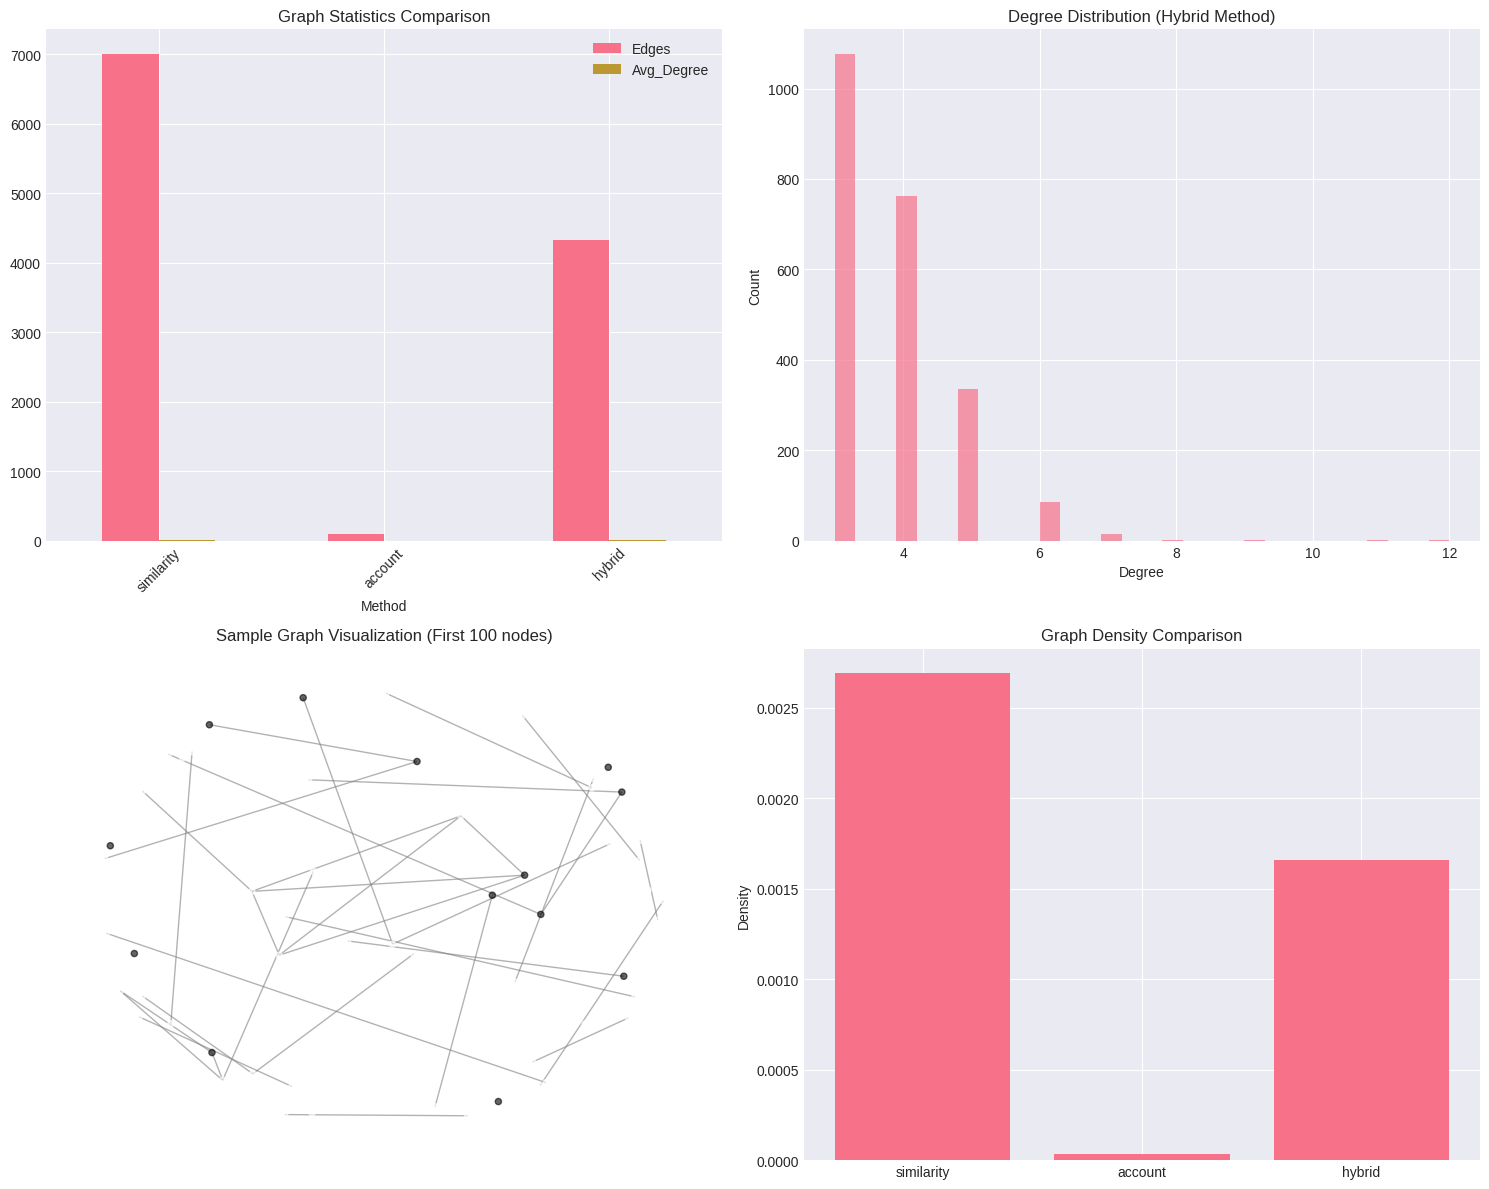


✅ Final graph selected: 2282 nodes, 4319 edges


In [5]:
# ==========================================
# STEP 5: IMPROVED GRAPH CONSTRUCTION
# ==========================================

def construct_meaningful_graph(df, X_net_std, method='hybrid', similarity_threshold=0.7, max_connections=5):
    """
    Construct graph with meaningful connections
    Methods: 'similarity', 'account', 'hybrid'
    """
    G = nx.Graph()

    # Add nodes with features
    for idx in range(len(df)):
        G.add_node(idx, features=X_net_std[idx])

    if method == 'similarity':
        # Similarity-based edges
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            # Find most similar posts
            similarities = similarity_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][1:max_connections+1]  # Exclude self
            for j in similar_indices:
                if similarities[j] > similarity_threshold:
                    G.add_edge(i, j, weight=similarities[j])

    elif method == 'account':
        # Account-based edges (limited)
        account_groups = df.groupby('account_id').indices
        for account_id, indices in account_groups.items():
            indices = list(indices)
            if len(indices) > 1:
                # Connect only recent posts (limit connections)
                for i in range(min(len(indices), max_connections)):
                    for j in range(i + 1, min(len(indices), max_connections)):
                        G.add_edge(indices[i], indices[j], weight=1.0)

    elif method == 'hybrid':
        # Combination of both methods
        # First add account-based edges
        account_groups = df.groupby('account_id').indices
        for account_id, indices in account_groups.items():
            indices = list(indices)
            if len(indices) > 1:
                for i in range(min(len(indices), 3)):  # Limit account connections
                    for j in range(i + 1, min(len(indices), 3)):
                        G.add_edge(indices[i], indices[j], weight=1.0)

        # Then add similarity-based edges
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            similarities = similarity_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][1:4]  # Top 3 similar
            for j in similar_indices:
                if similarities[j] > similarity_threshold and not G.has_edge(i, j):
                    G.add_edge(i, j, weight=similarities[j])

    return G

# Test different graph construction methods
methods = ['similarity', 'account', 'hybrid']
graphs = {}

for method in methods:
    print(f"\n🔄 Constructing graph with {method} method...")
    G = construct_meaningful_graph(df, X_net_std, method=method)
    graphs[method] = G
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    if G.number_of_nodes() > 0:
        degrees = [d for _, d in G.degree()]
        print(f"Average degree: {np.mean(degrees):.2f}")
        print(f"Degree std: {np.std(degrees):.2f}")

# Visualize graph statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Graph statistics comparison
stats_data = []
for method, G in graphs.items():
    if G.number_of_nodes() > 0:
        degrees = [d for _, d in G.degree()]
        stats_data.append({
            'Method': method,
            'Nodes': G.number_of_nodes(),
            'Edges': G.number_of_edges(),
            'Avg_Degree': np.mean(degrees),
            'Density': nx.density(G)
        })

stats_df = pd.DataFrame(stats_data)
stats_df.set_index('Method')[['Edges', 'Avg_Degree']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Graph Statistics Comparison')
axes[0,0].tick_params(axis='x', rotation=45)

# Degree distribution for hybrid method
if 'hybrid' in graphs:
    degrees = [d for _, d in graphs['hybrid'].degree()]
    axes[0,1].hist(degrees, bins=30, alpha=0.7)
    axes[0,1].set_title('Degree Distribution (Hybrid Method)')
    axes[0,1].set_xlabel('Degree')
    axes[0,1].set_ylabel('Count')

# Network visualization (sample)
if 'hybrid' in graphs and graphs['hybrid'].number_of_nodes() > 0:
    # Sample a subgraph for visualization
    sample_nodes = list(graphs['hybrid'].nodes())[:100]  # Sample first 100 nodes
    subgraph = graphs['hybrid'].subgraph(sample_nodes)

    pos = nx.spring_layout(subgraph, k=1, iterations=50)

    # Color nodes by labels
    node_colors = [y[node] for node in subgraph.nodes()]

    nx.draw(subgraph, pos, node_color=node_colors, node_size=20,
            with_labels=False, edge_color='gray', alpha=0.6, ax=axes[1,0])
    axes[1,0].set_title('Sample Graph Visualization (First 100 nodes)')

# Graph density comparison
methods_list = list(graphs.keys())
densities = [nx.density(graphs[method]) if graphs[method].number_of_nodes() > 0 else 0 for method in methods_list]
axes[1,1].bar(methods_list, densities)
axes[1,1].set_title('Graph Density Comparison')
axes[1,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Use hybrid method for final graph
final_graph = graphs['hybrid']
print(f"\n✅ Final graph selected: {final_graph.number_of_nodes()} nodes, {final_graph.number_of_edges()} edges")


PyTorch Geometric Data: Data(x=[2282, 3], edge_index=[2, 6601])
Using device: cuda
GCN embeddings shape: torch.Size([2282, 128])
NaN check: False


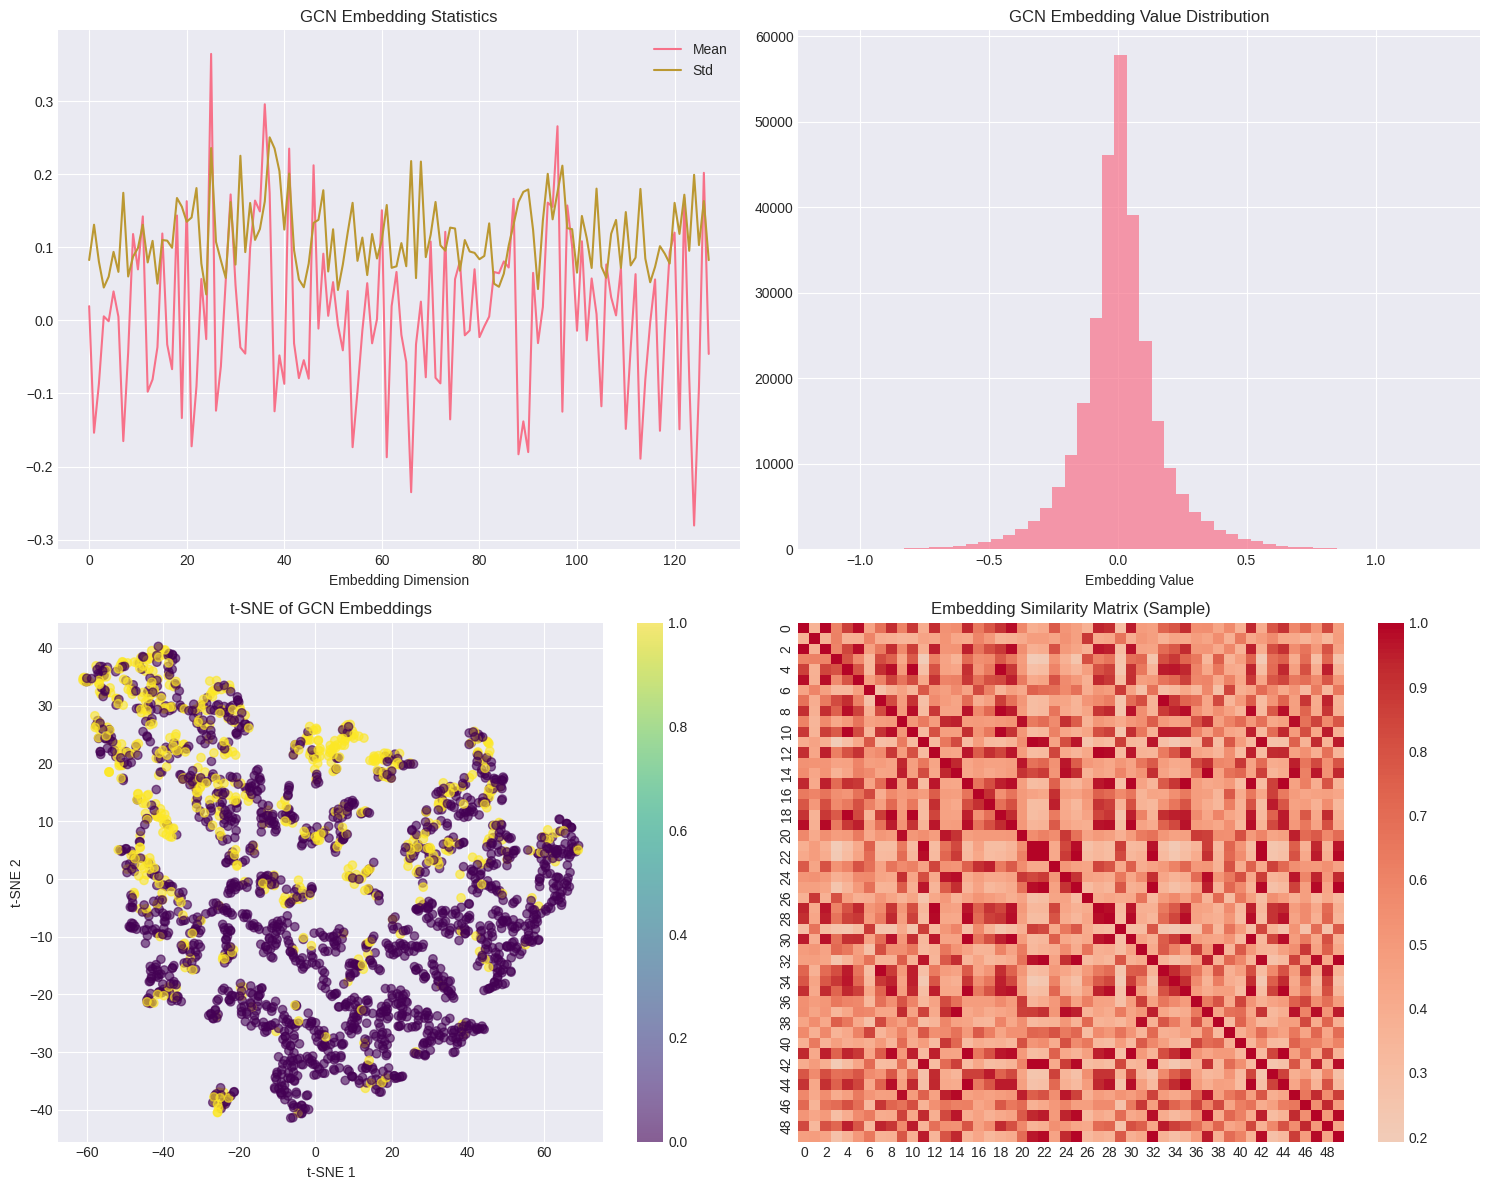

✅ GCN model and embeddings saved


In [7]:
# ==========================================
# STEP 6: GCN MODEL AND SOCIAL BRANCH
# ==========================================

# Convert NetworkX graph to PyTorch Geometric format
edges = list(final_graph.edges)
if len(edges) == 0:
    # Create self-loops for all nodes if graph is empty
    edge_index = torch.arange(len(df), dtype=torch.long).repeat(2, 1)
else:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # Ensure edge_index is of shape [2, num_edges]
    assert edge_index.shape[0] == 2, f"Edge index must have shape [2, num_edges], got {edge_index.shape}"

x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# Add self-loops
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index

print(f"PyTorch Geometric Data: {data}")

# Define improved GCN model
class ImprovedGCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128, dropout=0.3):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Third GCN layer
        x = self.conv3(x, edge_index)

        return x

# Initialize and train GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

gcn_model = ImprovedGCN().to(device)
data = data.to(device)

# Get GCN embeddings
gcn_model.eval()
with torch.no_grad():
    gcn_embeddings = gcn_model(data)

print(f"GCN embeddings shape: {gcn_embeddings.shape}")
print(f"NaN check: {torch.isnan(gcn_embeddings).any().item()}")

# Visualize GCN embeddings
gcn_embeddings_cpu = gcn_embeddings.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Embedding statistics
embedding_stats = pd.DataFrame({
    'Mean': gcn_embeddings_cpu.mean(axis=0),
    'Std': gcn_embeddings_cpu.std(axis=0),
    'Min': gcn_embeddings_cpu.min(axis=0),
    'Max': gcn_embeddings_cpu.max(axis=0)
})

embedding_stats[['Mean', 'Std']].plot(ax=axes[0,0])
axes[0,0].set_title('GCN Embedding Statistics')
axes[0,0].set_xlabel('Embedding Dimension')

# 2. Embedding distribution
axes[0,1].hist(gcn_embeddings_cpu.flatten(), bins=50, alpha=0.7)
axes[0,1].set_title('GCN Embedding Value Distribution')
axes[0,1].set_xlabel('Embedding Value')

# 3. t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
gcn_tsne = tsne.fit_transform(gcn_embeddings_cpu)

scatter = axes[1,0].scatter(gcn_tsne[:, 0], gcn_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[1,0].set_title('t-SNE of GCN Embeddings')
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Embedding similarity heatmap (sample)
sample_indices = np.random.choice(len(gcn_embeddings_cpu), 50, replace=False)
sample_embeddings = gcn_embeddings_cpu[sample_indices]
similarity_matrix = cosine_similarity(sample_embeddings)

sns.heatmap(similarity_matrix, ax=axes[1,1], cmap='coolwarm', center=0)
axes[1,1].set_title('Embedding Similarity Matrix (Sample)')

plt.tight_layout()
plt.show()

# Save GCN model and embeddings
torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/improved_gcn_model.pth')
torch.save(gcn_embeddings.cpu(), '/content/drive/MyDrive/Projects/Hayat/gcn_embeddings.pt')
print("✅ GCN model and embeddings saved")

# ==========================================